# Analyze movement based on Accelerometer Data

In [1]:
# Importing Python and external packages
import os
import sys
import importlib
import json
import csv
from dataclasses import dataclass, field, fields
from collections import namedtuple
from itertools import compress, product
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
from  matplotlib import __version__ as plt_version
from scipy import signal, stats

# import datetime as dt
# #mne
# import mne_bids
# import mne


In [2]:
def get_project_path_in_notebook(
    subfolder: str = '',
):
    """
    Finds path of projectfolder from Notebook.
    Start running this once to correctly find
    other modules/functions
    """
    path = os.getcwd()

    while path[-20:] != 'dyskinesia_neurophys':

        path = os.path.dirname(path)
    
    return path

In [3]:
# define local storage directories
projectpath = get_project_path_in_notebook()
codepath = os.path.join(projectpath, 'code')


In [4]:
os.chdir(codepath)

# own functions
import lfpecog_features.moveDetection_preprocess as movePrep
import lfpecog_features.moveDetection_run as run_tap_detect
import lfpecog_features.moveDetection_pausedTapFinder as findTap

import lfpecog_analysis.load_SSD_features as load_ssd_fts
import lfpecog_analysis.get_acc_task_derivs as accDerivs

import utils.utils_fileManagement as utilsFiles
from utils.utils_fileManagement import (get_project_path,
                                        load_class_pickle,
                                        save_class_pickle,
                                        mergedData,
                                        correct_acc_class)
import lfpecog_preproc.preproc_import_scores_annotations as importClin
import lfpecog_plotting.plotHelpers as plotHelp

In [5]:
# check some package versions for documentation and reproducability
print('Python sys', sys.version)
print('pandas', pd.__version__)
print('numpy', np.__version__)
print('matplotlib', plt_version)
# Python sys 3.9.0 (default, Nov 15 2020, 08:30:55) [MSC v.1916 64 bit (AMD64)]
# pandas 1.4.4
# numpy 1.23.3
# matplotlib 3.5.3

# STATS developed with:
# Python sys 3.10.8 (main, Nov  4 2022, 13:42:51) [MSC v.1916 64 bit (AMD64)]
# pandas 1.5.3
# numpy 1.26.2
# matplotlib 3.8.2

Python sys 3.9.0 (default, Nov 15 2020, 08:30:55) [MSC v.1916 64 bit (AMD64)]
pandas 1.4.4
numpy 1.23.3
matplotlib 3.5.3


### 0. Define available Subjects


In [6]:
import lfpecog_analysis.movement_psd_analysis as movePSD
import lfpecog_features.feats_helper_funcs as ftHelpers
import lfpecog_analysis.prep_movement_psd_analysis as prepMovePSD

import lfpecog_features.get_ssd_data as ssd
import lfpecog_analysis.ft_processing_helpers as ftProc


In [ ]:
FT_VERSION='v6'
SETTINGS = utilsFiles.load_ft_ext_cfg(FT_VERSION=FT_VERSION)

main_data_path = os.path.join(get_project_path('data'),
                              'merged_sub_data',
                              SETTINGS["DATA_VERSION"])

SUBS = utilsFiles.get_avail_ssd_subs(DATA_VERSION=SETTINGS["DATA_VERSION"],
                                     FT_VERSION=FT_VERSION)
print(len(SUBS))


## 1. Spectral analysis - split on movement-task-dyskinesia

In [ ]:
sub = '019'

sub_data_path = os.path.join(get_project_path('data'),
                             'merged_sub_data',
                             SETTINGS["DATA_VERSION"],
                             f'sub-{sub}')
fname = (f'{sub}_mergedData_{SETTINGS["DATA_VERSION"]}'
        '_acc_left.P')  # side does not matter for already detected bool labels

# load Acc-detected movement labels
accl = load_class_pickle(os.path.join(sub_data_path, fname))
accl = correct_acc_class(accl)

fname = (f'{sub}_mergedData_{SETTINGS["DATA_VERSION"]}'
        '_acc_right.P')  # side does not matter for already detected bool labels

# load Acc-detected movement labels
accr = load_class_pickle(os.path.join(sub_data_path, fname))
accr = correct_acc_class(accr)



In [ ]:
print(accl.data.shape, accl.fs, accl.colnames)
print(accr.data.shape, accr.fs, accr.colnames)

In [ ]:

# call from feats_extract_multivar.py
ssd_sub = ssd.get_subject_SSDs(
    sub=sub,
    incl_stn=True,
    incl_ecog=False,
    ft_setting_fname='ftExtr_spectral_v6.json',)

In [ ]:
# # get boolean arrays for movement labels corresponding to ephys
# ephys_arr = ssd_sub.lfp_left.lo_beta
# ephys_wintimes = np.array(ssd_sub.lfp_left.times)
# ephys_fs = ssd_sub.lfp_left.fs
# WINLEN_SEC = 10

# # create timestamps for every ephys sample in 2d array (2048 Hz)
# ephys_times2d = np.array([
#     np.arange(t, t + WINLEN_SEC, 1 / ephys_fs)
#     for t in ephys_wintimes
# ])
# nan_arr = np.isnan(ephys_arr)

# # get movement bools based on acc data (512 Hz)
# MOVE_BOOLS = {'no_move': accl.data[:, -1],
#               'any_move': np.sum(accl.data[:, -5:-1], axis=1) > 0,
#               'left_tap': accl.data[:, -5],
#               'left_allmove': (accl.data[:, -5] + accl.data[:, -3]) > 0,
#               'right_tap': accl.data[:, -4],
#               'right_allmove': (accl.data[:, -4] + accl.data[:, -2]) > 0}
# TASK = accl.data[:, 4]

In [ ]:
# CAT = False
# cdrs = ftProc.find_select_nearest_CDRS_for_ephys(
#     sub=sub, side='bilat',  
#     ft_times=ephys_wintimes / 60,
#     INCL_CORE_CDRS=True,
#     cdrs_rater='Patricia',
# )
 
# if CAT:
#     cdrs = ftProc.categorical_CDRS(cdrs,
#                             cutoff_mildModerate=3.5,
#                             cutoff_moderateSevere=7.5,)

In [ ]:
# importlib.reload(prepMovePSD)

# cdrs = ftProc.find_select_nearest_CDRS_for_ephys(
#     sub=sub, side='bilat',  
#     ft_times=ephys_wintimes / 60,
#     INCL_CORE_CDRS=True,
#     cdrs_rater='Patricia',
# )
# # cdrs = ftProc.categorical_CDRS(cdrs,
# #                             cutoff_mildModerate=3.5,
# #                             cutoff_moderateSevere=7.5,)

# mask_times = prepMovePSD.get_mask_timings(
#     orig_labels=cdrs,
#     orig_times=ephys_wintimes,
#     MASK='LID')

# # currently codes: rest=0, tap=1, free=2
# lid_mask = prepMovePSD.create_ephys_mask(
#     ephys_time_arr=ephys_times2d,
#     ephys_win_times=ephys_wintimes,
#     mask_times=mask_times,
#     MASK='LID',
# )

In [7]:
import lfpecog_analysis.psd_analysis_classes as psdClass
import lfpecog_analysis.specific_ephys_selection as ephySel

import lfpecog_plotting.plot_descriptive_SSD_PSDs as plot_ssd_PSDs
import lfpecog_plotting.plot_move_spec_psd as plot_specPsd
import lfpecog_analysis.prep_stats_movLidspecPsd as prep_specStats
import lfpecog_analysis.psd_lid_stats as psd_Stats

In [ ]:
importlib.reload(ephySel)
importlib.reload(prepMovePSD)
importlib.reload(psdClass)
importlib.reload(ssd)

# # get single subClass (incl original 3d data, always creates new)
# test = psdClass.PSD_vs_Move_sub(sub='014')

# use existing
sub = '109'
data_path = 'D://Research/CHARITE/projects/dyskinesia_neurophys/data/'
picklepath = os.path.join(
    data_path,
    'windowed_data_classes_10s_0.5overlap',
    'selected_ephys_classes_all'
)
picklename = f'ephys_selections_{sub}.P'

sub_class = load_class_pickle(
    file_to_load=os.path.join(picklepath,
                                picklename),
    convert_float_np64=True
)

In [ ]:
for src, sel in product(sub_class.ephys_sources,
                        sub_class.incl_selections):
    if src not in sel: continue
    if src != 'lfp_right': continue
    # if 'FREE' not in sel: continue
    print(sel, getattr(sub_class, sel).ephys_2d_arr.shape)

In [ ]:
getattr(sub_class, 'lfp_left_FREENOMOVE_moveboth_lidno').ephys_2d_arr

In [ ]:
importlib.reload(prepMovePSD)
# CHEWCK MASKS

move_masks, task_mask, lid_masks = prepMovePSD.create_ephys_masks(sub='012', verbose=True)

In [ ]:
np.sum(task_mask == 2) / 2048

In [ ]:
for MOV_TYPE in move_masks.keys():
    match_sum = np.sum(np.logical_and(
        move_masks[MOV_TYPE] == 1,
        task_mask == 2
    ))
    print(f'{MOV_TYPE} during FREE: {match_sum / 2048} seconds')


In [8]:
accl = accDerivs.get_raw_acc_traces(sub='012', side='left', data_version='v4.0')

... pickle loading: c:\Users\habetsj\Research\projects\dyskinesia_neurophys\data\merged_sub_data\v4.0\sub-012\012_mergedData_v4.0_acc_left.P


In [10]:
print(accl.colnames)

['dopa_time', 'ACC_L_X', 'ACC_L_Y', 'ACC_L_Z', 'task', 'left_tap', 'right_tap', 'left_move', 'right_move', 'no_move']


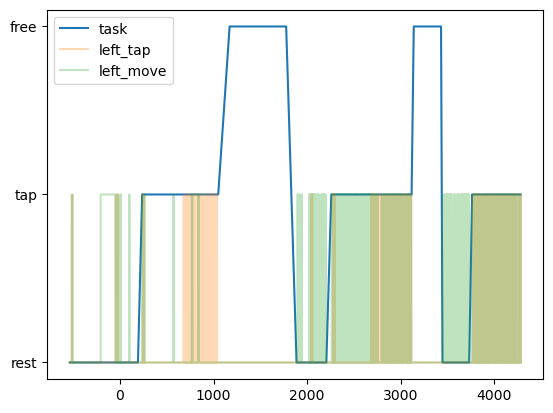

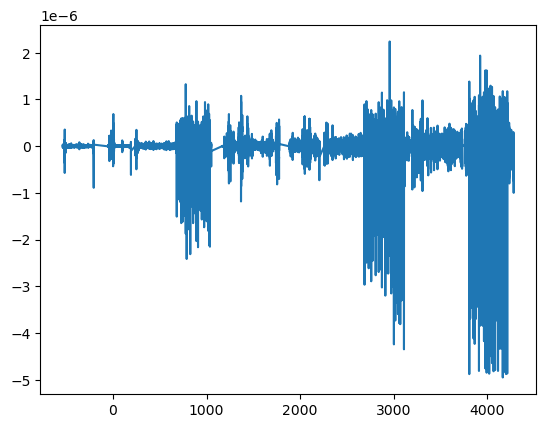

In [12]:
# MOVE BOOLS NOT RELIABLE FOR FREE; CHECK CREATION !!!!

plt.plot(accl.data[:, 0], accl.data[:, 4], label=accl.colnames[4])
plt.plot(accl.data[:, 0], accl.data[:, 5], alpha=.3, label=accl.colnames[5])
plt.plot(accl.data[:, 0], accl.data[:, 7], alpha=.3, label=accl.colnames[7],)

plt.legend()
plt.show()

plt.plot(accl.data[:, 0], accl.data[:, 1])
plt.show()

In [65]:
from scipy.signal import find_peaks
from scipy.ndimage import uniform_filter1d
import lfpecog_features.moveDetection_pausedTapFinder as tapFind

In [56]:
def find_move_moments(
    main_ax_sig, svm, sub, fs,
    large_height = 5e-7,
    small_height = 2.5e-7,
):
    """
    Find three different types of movement peaks
    that are similarly used for TAP detection
    
    - main_ax_sig:
    - svm: (smoothed!, on 250 ms)
    """
    # correct thresholds if necessary
    if max(main_ax_sig) > 1 and sub in ['105']:
        svm_thr = .05  # correct for incorrect ACC range
        large_height = .3
        small_height = .1
    elif max(main_ax_sig) > 1:
        svm_thr = .1  # correct for incorrect ACC range
        large_height = .5
        small_height = .3
    elif sub in ['105']:
        svm_thr = 5e-8  # correct for incorrect ACC range
        large_height = 3e-7
        small_height = 1e-7

    # Find peaks to help movement detection
    largePos = find_peaks(
        main_ax_sig,
        height=large_height,
        distance=fs,  # 1 s
    )[0]
    smallPeaks = find_peaks(
        svm,
        height=small_height,
        distance=fs,
    )[0]
    largeNeg = find_peaks(
        -1 * main_ax_sig,  # convert pos/neg for negative peaks
        height=large_height,
        distance=fs,
    )[0]

    all_peaks = np.sort(np.concatenate([largePos, smallPeaks, largeNeg]))

    # PEAKS into find_local_act_borders()
    return all_peaks

In [66]:
def specTask_movementClassifier(
    acc_class, task: str = 'free',
    svm_thr=1e-7,
    
):

    # select out task data
    task_idx = ['task' in c for c in acc_class.colnames]
    task_arr = acc_class.data[:, task_idx].ravel()  # ravel to reduce to 1d for indexing
    # select task moments
    task_sel = task_arr == task

    # select times
    time_idx = ['time' in c for c in acc_class.colnames]
    time_sel = acc_class.data[task_sel, time_idx]

    # select acc data
    acc_idx = ['ACC' in c for c in acc_class.colnames]
    acc_arr = acc_class.data[:, acc_idx]
    acc_sel = acc_arr[task_sel, :]

    # define main axis
    mainAx_ind = movePrep.find_main_axis(acc_arr)

    # calculate and smooth SVM
    svm = movePrep.signalvectormagn(acc_sel)  # svm for task data
    svm = uniform_filter1d(
        svm, size=int(acc_class.fs / 4)
    )
    # find peaks (indices corr to task selection)
    mov_peaks = find_move_moments(
        main_ax_sig=acc_sel[:, mainAx_ind],
        svm=svm, sub=acc_class.sub,
        fs=acc_class.fs,
    )
    print(f'# peaks found: {len(mov_peaks)}')
    # get borders of activity around movement peaks (idx corr to svm-indices)
    move_times = {'start': [], 'end': []}
    # prevents double peak processing if border is already set further
    last_border = -30 * 60 * acc_class.fs
    for p in mov_peaks:
        if p < last_border: continue
        i1, i2 = tapFind.find_local_act_borders(
            p, svm_sig=svm, svmThr=svm_thr,  # svm is already task selected
        )
        print(i1, i2, type(i1), type(i2))
        if isinstance(i1, bool): continue
        last_border = i2
        # convert svm (tasl-selected) indices to time, and apply as mask
        move_times['start'].append(time_sel[i1])
        move_times['end'].append(time_sel[i2])
    
    return move_times

In [67]:
importlib.reload(tapFind)

move_times = specTask_movementClassifier(acc_class=accl,)

# peaks found: 178
9631 10089 <class 'numpy.int64'> <class 'numpy.int64'>
32589 36021 <class 'numpy.int64'> <class 'numpy.int64'>
40548 41508 <class 'numpy.int64'> <class 'numpy.int64'>
41602 43186 <class 'numpy.int64'> <class 'numpy.int64'>
45942 47061 <class 'numpy.int64'> <class 'numpy.int64'>
60119 60460 <class 'numpy.int64'> <class 'numpy.int64'>
88398 89225 <class 'numpy.int64'> <class 'numpy.int64'>
89238 91504 <class 'numpy.int64'> <class 'numpy.int64'>
101066 102739 <class 'numpy.int64'> <class 'numpy.int64'>
107910 108719 <class 'numpy.int64'> <class 'numpy.int64'>
122396 123065 <class 'numpy.int64'> <class 'numpy.int64'>
133866 137280 <class 'numpy.int64'> <class 'numpy.int64'>
140155 141254 <class 'numpy.int64'> <class 'numpy.int64'>
160269 161736 <class 'numpy.int64'> <class 'numpy.int64'>
258270 259761 <class 'numpy.int64'> <class 'numpy.int64'>
259875 261050 <class 'numpy.int64'> <class 'numpy.int64'>
292263 295066 <class 'numpy.int64'> <class 'numpy.int64'>
295513 29607

ValueError: attempt to get argmin of an empty sequence

In [62]:
move_times['start']

[1188.810546875,
 1233.650390625,
 1249.1953125,
 1251.25390625,
 1259.73046875,
 1287.419921875,
 1342.65234375,
 1344.29296875,
 1367.39453125,
 1380.76171875,
 1409.0546875,
 1431.45703125,
 1443.740234375,
 1483.025390625,
 1674.43359375,
 1677.568359375,
 1740.826171875,
 1747.173828125,
 1748.533203125,
 1751.673828125,
 1755.01171875,
 1773.447265625,
 3141.078125,
 3143.462890625,
 3148.087890625,
 3153.029296875,
 3158.30859375,
 3162.236328125,
 3163.71875,
 3195.134765625,
 3204.3125,
 3207.259765625,
 3219.259765625,
 3223.478515625,
 3239.41015625,
 3241.81640625,
 3259.4765625,
 3262.154296875,
 3264.55078125,
 3275.35546875,
 3281.732421875,
 3286.2421875,
 3291.21484375,
 3294.484375,
 3300.091796875,
 3302.158203125,
 3303.916015625,
 3329.591796875,
 3344.8203125,
 3358.033203125,
 3361.384765625,
 3367.587890625,
 3369.50390625,
 3376.236328125,
 3379.658203125,
 3384.126953125,
 3393.125,
 3398.87890625,
 3413.880859375,
 3419.638671875,
 3423.01171875,
 array([], s

ValueError: setting an array element with a sequence.

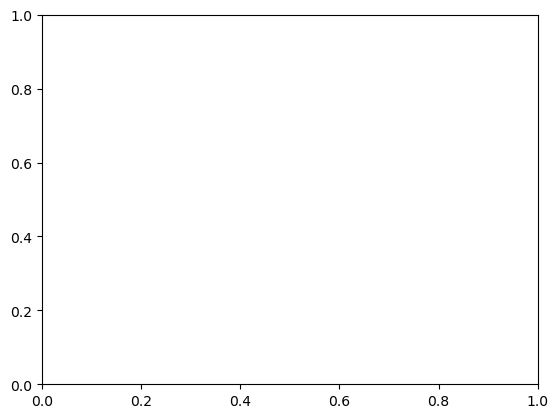

In [61]:
plt.scatter(move_times['start'],
            [0] * len(move_times['start']),)

plt.scatter(move_times['end'],
            [1] * len(move_times['end']),)

In [ ]:
FIG_PATH = os.path.join(get_project_path('figures'),
                        'ft_exploration',
                        'data_v4.0_ft_v6',
                        'PSDs_state_specific')

In [ ]:
# IMPORT CLASSES OF ALL CONDITIONS

importlib.reload(ephySel)
importlib.reload(psdClass)

RETURN_PSD_1sec = True

(
    PSDs_1s, BLs_1s
) = psdClass.get_allSpecStates_Psds(
    RETURN_PSD_1sec=RETURN_PSD_1sec
)


cond_colors = {
    'nolid': 'green',
    'nolidbelow30': 'limegreen',
    'nolidover30': 'darkgreen',
    'alllid': 'blue', 'mildlid': 'orange',
    'moderatelid': 'red', 'severelid': 'purple',
}

Plot REST or MOVEMENTS: Voluntary (TAP) / Involuntary (LID) versus CONTRA and IPSI-LATERAL Ephys

- movement selection has millisecond resolution

In [ ]:
importlib.reload(psdClass)
importlib.reload(ephySel)
importlib.reload(plot_ssd_PSDs)
importlib.reload(plot_specPsd)

# PLOT DYSKINESIA STATES

%matplotlib inline
# %matplotlib qt
INCL_STATS = True
# plot_PSDs, plot_BLs = psdClass.get_allSpecStates_Psds(RETURN_PSD_1sec=False)

for PLOT_SEL in ['REST', 'TAP', 'INVOLUNT']:
    
    if PLOT_SEL != 'REST':
        print(f'\n...SKIP {PLOT_SEL}')
        continue
    
    print(f'PLOT {PLOT_SEL}, (incl STATs: {INCL_STATS})')
    plot_specPsd.prep_and_plot_moveSpecPsd(
        PLOT_CONDITION=PLOT_SEL, PSD_DICT=plot_PSDs,
        BASELINE=plot_BLs,
        SAVE_PLOT=True, SHOW_PLOT=False,
        INCL_STATS=True,
        STAT_LID_COMPARE='linear',
        MERGE_REST_STNS=True,
    )

# psd_arrs, psd_freqs = plot_specPsd.prep_MOVEMENT_spec_psds(
#     PLOT_MOVE=PLOT_MOVE, PSD_DICT=PSDs,
#     BASELINE=BLs,
# )

# # PLOT_MOVE = 'REST'
# # psd_arrs, psd_freqs = plot_specPsd.prep_REST_spec_psds(
# #     PSD_DICT=PSDs, BASELINE=BLs,
# # )

# plot_specPsd.plot_moveLidSpec_PSDs(
#     psd_arrs, psd_freqs=psd_freqs,
#     PLOT_MOVE_TYPE=PLOT_MOVE,
#     SAVE_PLOT=True,
# )


Add STATS to PSD plotting

In [ ]:
importlib.reload(plot_specPsd)



# dev STATS
SOURCES = ['lfp_left', 'ecog']

(psd_arrs,
 psd_freqs,
 psd_subs) = plot_specPsd.prep_REST_spec_psds(
    PLOT_MOVE='REST',
    PSD_DICT=PSDs,
    BASELINE=BLs,
    RETURN_IDS=True
)

src_psd = psd_arrs[SOURCES[0]].copy()
src_subs = psd_subs[SOURCES[0]].copy()
MOVE_STATES = list(src_psd.keys())
print(MOVE_STATES)

temp_psd = src_psd[MOVE_STATES[0]]
temp_subs = src_subs[MOVE_STATES[0]]

LID_STATES = ['nolid', 'mildlid', 'moderatelid', 'severelid']

temp_lid = LID_STATES[1]


# assert len(temp_psd[temp_lid]) == len(temp_subs[temp_lid]), (
#     'psd_arrs and psd_subs DONT MATCH'
# )

new_subs = [[temp_subs[i]] * temp_psd[i].shape[0]
            for i in np.arange(len(temp_psd))]
new_subs = [s for l in new_subs for s in l]
new_psds = np.array([row for arr in temp_psd for row in arr])
assert len(new_psds) == len(new_subs), '1sec unnesting shapes incorrect'

In [ ]:
# CREATE AND/OR PLOT SIGNIFICANCIES PER SELECTION (binary / linear)

importlib.reload(plot_specPsd)
importlib.reload(prep_specStats)
importlib.reload(psd_Stats)

prep_specStats.get_stats_REST_psds(
    STAT_DATA_EXT_PATH = True,
    STAT_LID_COMPARE = 'linear',
    PLOT_STATS=True,
    MERGE_STNs=True,
)


# prep_specStats.get_stats_MOVE_psds(
#     STAT_DATA_EXT_PATH = True,
#     STAT_LID_COMPARE = 'linear',
#     PLOT_STATS = True,
# )


check original large subject pickles

TEST GAMMA BETA THETA IDEA

In [ ]:
data_path = 'D://Research/CHARITE/projects/dyskinesia_neurophys/data/'
picklepath = os.path.join(
    data_path,
    'windowed_data_classes_10s_0.5overlap',
    'selected_ephys_classes_all'
)

SUB = '105'

picklename = f'ephys_selections_{SUB}.P'

sub_class = load_class_pickle(
    file_to_load=os.path.join(picklepath,
                                picklename),
    convert_float_np64=True
)

In [ ]:
# %matplotlib qt
%matplotlib inline

### ### NOTES on DETAILED DATA SELECTION ### # 

- To Do:
    - create FREE-task data (LID-categories, mov/ no-move)
    - plot unilat-dyskinesia in IPSI and CONTRA hemisphere (STN and ECoG)


In [ ]:
# importlib.reload(ephySel)

# # now incorporated and saved in subclasses
# sel_ephys, sel_times, sel_cdrs, sel_task = ephySel.select_3d_ephys_moveTaskLid(
#     psdMoveClass=test, ephys_source='lfp_left',
#     SEL='BASELINE', SEL_bodyside='both',
#     DYSK_SEL='all', DYSK_UNILAT_SIDE='false', EXCL_ECOG_IPSILAT=False,
#     verbose=True,
# )

# %matplotlib qt
# %matplotlib inline
# ephySel.plot_check_ephys_selection(
#     sel_times=sel_times, sel_ephys=sel_ephys,
#     sel_task=sel_task, sel_cdrs=sel_cdrs
# )

# older scripts

tap overviews plotted in movement_psd_analysis.plot_overview_tap_detection

### 1a. Load pickled acc-data (and plot Taps)


### 1b. Load SSD data

load dataclass with features, labels, and acc

In [ ]:

# importlib.reload(ftProc)

# class created in ftProc, FeatLidClass()
# mean-RMS standardly zscored
import lfpecog_analysis.ft_processing_helpers as ftProc

featLabPath = os.path.join(utilsFiles.get_project_path('data'),
                           'prediction_data',
                           'featLabelClasses')
feats6 = utilsFiles.load_class_pickle(
    os.path.join(featLabPath, 'featLabels_ftv6_Cdrs_StnOnly.P'),
    convert_float_np64=True
)

### 2. Explore ACC-activity analysis

In [ ]:
clrs = list(plotHelp.get_colors('PaulTol').values())

In [ ]:
importlib.reload(accDerivs)

In [ ]:
# raw_rms = load_matching_acc_rms(sub='008', RMS_ZSCORE=True,
#                             FT_VERSION=feats6.FT_VERSION,
#                             DATA_VERSION=feats6.DATA_VERSION)

dat = accDerivs.get_raw_acc_traces(sub='008', side='left',
                        data_version=feats6.DATA_VERSION)

In [ ]:
# PLOT RAW-ACC VS FEAT-RMS AND TASK

sub = '008'

FS=16  # fontsize

# sub = 
# get rms per 10 seconds
rms = feats6.ACC_RMS[sub]
rms_t = feats6.FEATS[sub].index.values  # is in minutes

# raw_rms = load_matching_acc_rms(sub=sub, RMS_ZSCORE=False,
#                             FT_VERSION=feats6.FT_VERSION,
#                             DATA_VERSION=feats6.DATA_VERSION)
    
fig, ax = plt.subplots(1,1, figsize=(8, 4))

# plot signal vector magnitude
for side, col in zip(['left', 'right'],
                     ['blue', 'orangered']):
    dat = get_raw_acc_traces(sub=sub, side=side,
                             data_version=feats6.DATA_VERSION)
    acc_axes = ['ACC_' in c for c in dat.colnames]
    svm = movePrep.signalvectormagn(dat.data[:, acc_axes])
    ax.scatter(dat.times / 60, svm, facecolor='w', alpha=.3,
                edgecolor=col, s=20, label=f'raw ACC-{side}')
    
ax.set_ylabel('raw ACC-SVM (a.u.)', size=FS,
              color='k',weight='bold',)

ax2 = ax.twinx()

# plot windowed RMS
ax2.scatter(rms_t, rms, s=50,
            alpha=.5, color='darkorange',
            label='mean ACC-RMS')
ax2.set_ylabel('Windowed ACC-RMS\nz-scored (a.u.)',
               size=FS, color='darkorange',
               weight='bold',)

# shade tasks
for i_task, task in enumerate(['rest', 'tap', 'free']):
    task_sel = dat.data[:, task_col] == task
    ax.fill_between(x=(dat.times/60).astype(np.float64),
                    where=task_sel,
                    y1=0, y2=7e-6,
                    alpha=.3,
                    color=clrs[i_task*2],
                    # hatch='//',  facecolor='w',
                    label=task)

plt.title(f'Movement overview during experiment, sub-{sub}',
          size=FS, weight='bold', y=1.08,)

ax.legend(ncol=3, loc='upper center',
          frameon=False, fontsize=FS-4,
          bbox_to_anchor=(.5, 1.05))

for AX in [ax, ax2]:
    AX.tick_params(axis='both', size=FS, labelsize=FS)
    AX.spines['top'].set_visible(False)
    # AX.spines['right'].set_visible(False)

plt.tight_layout()

plt.savefig(os.path.join(get_project_path('figures'),
                         'protocol',
                         f'movement_ex_{sub}'),
            dpi=300, facecolor='w',)

plt.close()

In [ ]:
def load_matching_acc_rms(sub, FT_VERSION,
                          DATA_VERSION,
                          ACC_SIDE='mean',
                          RMS_ZSCORE = False,
                          WIN_LEN_sec=10,
                          WIN_OVERLAP=0.5):
    """
    duplicate of in-class function in FeatLidClass,
    use to get non-zscored-RMS
    """

    acc_rms_path = os.path.join(utilsFiles.get_project_path('results'),
                                'features',
                                f'SSD_feats_broad_{FT_VERSION}',
                                DATA_VERSION,
                                f'windows_{WIN_LEN_sec}s_'
                                f'{WIN_OVERLAP}overlap')


    rms_fname = f'windowed_ACC_RMS_{sub}.json'
    rms_fpath = os.path.join(acc_rms_path, rms_fname)

    if rms_fname in os.listdir(acc_rms_path):
        with open(rms_fpath, 'r') as f:
            sub_rms = json.load(f)
        
        if ACC_SIDE == 'mean':
            rms = np.array(sub_rms['left']) + np.array(sub_rms['right'])
        else: rms = sub_rms[ACC_SIDE]

        if RMS_ZSCORE: rms = (rms - np.mean(rms)) / np.std(rms)

    else:
        rms = accDerivs.get_acc_rms_for_windows(
            sub=sub, acc_side=ACC_SIDE, Z_SCORE=RMS_ZSCORE,
            featClass=feats6, SAVE_RMS=True,)
    
    return rms

In [ ]:
rms = load_matching_acc_rms(sub='103', FT_VERSION='v6',
                            DATA_VERSION='v4.0',)

In [ ]:
rms.shape

### 3. Explore Movement vs PSD analysis

In [ ]:
FT_VERSION='v6'
DATA_VERSION = 'v4.0'
main_data_path = os.path.join(get_project_path('data'),
                              'merged_sub_data',
                              DATA_VERSION)

SUBS = load_ssd_fts.get_avail_ssd_subs(DATA_VERSION=DATA_VERSION,
                                       FT_VERSION=FT_VERSION)
print(len(SUBS))

In [ ]:
importlib.reload(prepTapPSD)

for sub in SUBS:
    
    print(f'start sub-{sub}')
    prepTapPSD.create_sub_movement_psds(
        sub=sub,
        data_version=DATA_VERSION,
        ft_version=FT_VERSION,
        states_to_save=['tap',])


In [ ]:
def unpack_list_of_lists(lists_to_unpack):

    new_list = [i for j in lists_to_unpack for i in j]

    return new_list

In [ ]:
colors = list(plotHelp.get_colors().values())

In [ ]:
importlib.reload(movePSD)

# psd_rest, psd_tap, tap_f = movePSD.load_movement_psds()
state_psds, tap_f = movePSD.load_movement_psds()


In [ ]:
state_psds.keys()

In [ ]:
importlib.reload(movePSD)


movePSD.plotPSD_rest_vs_tap(PSDs=state_psds,
                           freqs=tap_f,
                           data_version=data_version,
                           n_subs_incl=17,
                           fig_name='STN_PSDs_Tap_vs_Rest_vs_Free'
                        )

#### 1b) Import processed dataclass per subject, optionally merge ACC-data into EPHYS-df

In [ ]:
# # Import subjectData Classes with alligned preprocessed Data
# importlib.reload(read_data)
# importlib.reload(add_moveStates)
# importlib.reload(findTap)

# incl_accStates = True

# subData = {}

# for sub in ['012', '014']:

#     print(f'start {sub}')
#     # if sub == '008': continue

#     subData[sub] = read_data.subjectData(
#         sub=sub,
#         data_version='v2.3',
#         project_path=projectpath,
#     )

#     if incl_accStates:
        
#         accStates = run_tap_detect.runTapDetection(subData[sub])

#         for group in subData[sub].dtypes:

#             if 'lfp' or 'ecog' in group:

#                 print(f'adding acc-states for {sub}: {group}')
#                 newdf = add_moveStates.add_detected_acc_states(
#                     df=getattr(subData[sub], group).data,
#                     detectedMoves=accStates,
#                 )
#                 getattr(subData[sub], group).data = newdf

### 2) Develop and Visualise Movement State Detection


#### Run single Acc-State Detections


In [ ]:
importlib.reload(run_tap_detect)
importlib.reload(movePrep)
importlib.reload(findTap)

taplists = {}
for sub in ['012',  '014']:  # '008', '013',
    print(sub)
    taplists[sub] = run_tap_detect.runTapDetection(subData[sub])

#### Visualise Performance of Tap/Move-detection

In [ ]:

fonts=20

for sub in list(subData.keys()):

    for x0, x1 in zip(
        # [9, 42],
        # [10, 43]
        [5, 37,],
        [15, 42]
    ):

        fig, axes = plt.subplots(2, 1, figsize=(16, 8))

        for s, side in enumerate(['left', 'right']):

            acc_df = getattr(subData[sub], f'acc_{side}').data  # per side
            fs = getattr(subData[sub], f'acc_{side}').fs

            ax = movePrep.find_main_axis(
                acc_df.iloc[:, 1:4].values
            )
            svm = movePrep.signalvectormagn(
                acc_df.iloc[:, 1:4].values
            )

            axes[s].plot(
                acc_df['dopa_time'] / 60,
                acc_df.iloc[:, ax + 1],
                alpha=.4, label='uni-axis'
            )
            axes[s].plot(
                acc_df['dopa_time'] / 60,
                movePrep.signalvectormagn(
                    acc_df.iloc[:, 1:4].values
                ), alpha=.4, label='svm', c='r', ls='dotted',
            )

            axes[s].scatter(
                np.array([l[0] for l in taplists2[sub][f'{side}_tap_t']]) / 60,
                [.65e-6] * len(taplists2[sub][f'{side}_tap_t']),
                s=50, color='g', label='tap-start',
            )
            axes[s].scatter(
                np.array([l[-1] for l in taplists2[sub][f'{side}_tap_t']]) / 60,
                [.6e-6] * len(taplists2[sub][f'{side}_tap_t']),
                s=50, color='r', label='tap-end'
            )
            axes[s].scatter(
                np.array([m[0] for m in taplists2[sub][f'{side}_move_t']]) / 60,
                [.55e-6] * len(taplists2[sub][f'{side}_move_t']),
                s=50, color='orange', label='move-start'
            )
            axes[s].scatter(
                np.array([m[1] for m in taplists2[sub][f'{side}_move_t']]) / 60,
                [.5e-6] * len(taplists2[sub][f'{side}_move_t']),
                s=50, color='purple', label='move-end'
            )

            axes[s].set_xlim(x0, x1)
            axes[s].set_ylim(-1e-6, 1e-6)
            axes[s].set_ylabel(
                f'Acceleration\n{side.upper()}'
                    '\n(g, m/s/s)',
                size=fonts
            )
            axes[s].tick_params(labelsize=fonts - 4)

        axes[s].set_xlabel('Time (minutes to L-Dopa intake)', size=fonts)


        plt.suptitle(
            f'Subject {sub} -  bilateral '
            'Movement detection',
            x=.1, y=.96, ha='left',
            size=fonts+4
        )
        # remove duplicate legend labels
        handles, labels = plotHelp.remove_duplicate_legend(
            plt.gca().get_legend_handles_labels()
        )

        fig.legend(
            handles, labels,
            frameon=False, fontsize=fonts - 4, ncol=3,
            loc='center left', bbox_to_anchor = [.55, .95])
        
        plt.tight_layout()

        # plt.savefig(os.path.join(
        #     fig_dir, 'tapping_detection',
        #     f'sub{sub}_moveDetect_newBorders_min{x0}_{x1}'
        # ), dpi=150, facecolor='w',)

        plt.close()

### VIsualisation Features

#### Manual Video-Movement Annotation

In [ ]:
# annotate observed taps in video, integers are seconds
# from video start
# CAVE: orignal Video-starttime is hour in front
# values here are corrected one hour backwards (12->11)
# Still the video-time seems to be +/- 3 minutes behind
# the acc-neurophys-time
taptimes_video = {
    'SelfpacedHandTapL_StimOffDopa15': {
        'left': [
            1154, 1160, 1164, 1169, 1174, 1180, 1185,
            1191, 1195, 1201, 1207, 1226, 1238, 1243,
            1248, 1253
        ],
        'right':[
            1260, 1264, 1270, 1275, 1281, 1290, 1298,
            1303, 1308, 1313, 1320, 1324, 1332, 1339,
            1345
        ],
        'starttime': '2021-11-15 11:29' 
        # original 11:26 but corrected for mismatching times
    },
    'SelfpacedHandTapL_StimOffDopa35': {
        'left': [
            878, 883, 888, 893, 898, 903, 908, 915,
            919, 926, 933, 946, 951, 957, 963, 970,
            976, 984
        ],
        'right':[
            1000, 1006, 1011, 1017, 1024, 1028, 1035,
            1041, 1054, 1060, 1081, 1089, 1097, 1103,
            1108
        ],
        'starttime': '2021-11-15 11:51:01'
        # original 11:48 but corrected for mismatching times
    },
    'SelfpacedHandTapL_StimOffDopa60': {
        'left': [
            641, 647, 652, 657, 662, 666, 671, 676,
            682, 686, 692, 697, 703, 708, 713, 719,
        ],
        'right':[
            726, 730, 734, 740, 746, 751, 756, 761,
            768, 773, 779, 784, 792, 797, 801
        ],
        'starttime': '2021-11-15 12:22:59'  # video S1290007
        # original 12:20 but corrected for mismatching times
    }
}
# add timedelta in seconds to start-time of video
# CAVE videostarttime is on MINUTE-RESOLUTION
# thus will be SECONDS OF FROM ACC-TIMESTAMP
for run in taptimes_video:
    starttime = pd.Timestamp(taptimes_video[run]['starttime'])
    for side in ['left', 'right']:
        taptimes_video[run][f'{side}_stamps'] = []
        for sec in taptimes_video[run][side]:
            delta = pd.Timedelta(sec, 'sec')
            taptimes_video[run][f'{side}_stamps'].append(
                starttime + delta)

# Save annotation dict
# deriv_dir = os.path.join(
#     projectpath, 'data', 'analysis_derivatives', 'sub-008', 'taps'
# )
# dict_name = f'008_video_ann_tapruns'
# np.save(os.path.join(deriv_dir, dict_name),
#         taptimes_video)

# # Load annotation dict
# video_taps = np.load(os.path.join(deriv_dir, f'{dict_name}.npy'),
#                      allow_pickle=True).item()


In [ ]:
sub = '008'
annot_dir = os.path.join(projectpath, f'data/analysis_derivatives/sub-{sub}/taps')
testannot = np.load(os.path.join(annot_dir, f'{sub}_video_ann_tapruns.npy'),
    allow_pickle=True).item()
# testannot


#### Automated Acc-based Tap detection incl. plotting

In [ ]:
run = 'SelfpacedHandTapL_StimOffDopa35'
sides = ['left', 'right']
tap_fig_dir = os.path.join(projectpath, 'figures/tapping_detection')

In [ ]:
importlib.reload(tap_run)

restTest, tapTest, _ = tap_run.runTapDetection(
    task='paused', fs=SUB08.runs[run].acc_right_Fs,
    leftxyz=[accleft[run][0, :], accleft[run][1, :],
    accleft[run][2, :]], rightxyz=[accright[run][0, :],
    accright[run][1, :], accright[run][2, :]],
)

In [ ]:
### Main function to perform TapDetection functions
    ## make new main-function

importlib.reload(Tap2)

# accright, accleft = {}, {}
# restDict, tapDict, moveDict = {}, {}, {}

for run in SUB08.runs_incl[1:]:
    print(f'Start RUN: {run}')
    fs=SUB08.runs[run].acc_right_Fs
    accright[run] = SUB08.runs[run].acc_right_arr[1:, :]
    accleft[run] = SUB08.runs[run].acc_left_arr[1:, :]

    restDict[run], tapDict[run], moveDict[run] = runTapDetection(
        task='paused', fs=SUB08.runs[run].acc_right_Fs,
        leftxyz=[accleft[run][0, :], accleft[run][1, :],
        accleft[run][2, :]], rightxyz=[accright[run][0, :],
        accright[run][1, :], accright[run][2, :]],
    )


In [ ]:
### (function to be) get runstartTimes (include in RUN CLASS (real and dopa times))
deriv_dir = os.path.join(projectpath, 'data/analysis_derivatives')
runTimes = pd.read_excel(
    os.path.join(deriv_dir, f'sub-{sub}', f'sub{sub}_runsInfo.xlsx'))

runStartTimes = {}
for run in SUB08.runs_incl:
    for row in np.arange(runTimes.shape[0]):
        if run[-6:] in runTimes.iloc[row]['filename']:
            t = runTimes.iloc[row]['acq_time']
            runStartTimes[run] = pd.Timestamp(t)

In [ ]:
### Import and process video-annotated tap-times ###

## (function to be) Convert video-annotated tap-stamps
## into seconds after tmsi-recording

# import annotated taptimes (function to be?)
sub = '008'
annot_dir = os.path.join(projectpath, f'data/analysis_derivatives/sub-{sub}/taps')
tapAnnot = np.load(os.path.join(annot_dir, f'{sub}_video_ann_tapruns.npy'),
    allow_pickle=True).item()

ann_times = {}
tapsAnnot_in_runSecs = {}

for run in tapDict.keys():
    if 'Tap' not in run: continue

    # real-time timestamps of video-annotated taps
    dt_string = '%Y-%m-%d %H:%M:%S'
    t0 = tapAnnot[run]['starttime']
    try:
        t0 = dt.datetime.strptime(t0, dt_string)
    except ValueError:
        t0 = dt.datetime.strptime(t0, '%Y-%m-%d %H:%M')

    ann_times[run] = {}
    tapsAnnot_in_runSecs[run] = {}

    for side in sides:
        ann_times[run][side] = [t0 + dt.timedelta(
            seconds=t) for t in tapAnnot[run][side]]
    # minus video start-time -> time after video-start
        tapsAnnot_in_runSecs[run][side] = [
            (t - runStartTimes[run]).total_seconds(
            ) for t in ann_times[run][side]
        ]


In [ ]:
### TO DO:
# - WHY IS check_Polarity turning the signal falsely?
# - Why is tapdetection from TapDopa15 Right empty? 
    # plot incl peaks and thresholds etc

# - include plotting of OTHER MVOEMENTS
# - split py function for tapping in several py docs!!

In [ ]:
### Create plotting functions for tapping

from matplotlib.gridspec import GridSpec

run = list(tapsAnnot_in_runSecs.keys())[2]

print(f'Plot Figure for run {run}')
# specify x-coordinates of zoomed-in subplots
ax1_x1, ax1_x2 = 72, 80
ax2_x1, ax2_x2 = 150, 160
plot_fname=f'TapDetect_08_{run}'
if ax1_x1: plot_fname += f'_zooms_{ax1_x1}_{ax2_x1}'
plot_fdir=tap_fig_dir

plot_params = {
        'left': {
            'color': 'b',
            'alpha': .6
        },
        'right': {
            'color': 'g',
            'alpha': .6
        },
        'rest': {
            'color': 'orange',
            'alpha': .3
        },
        'left_up': {
            'color': 'dodgerblue',
            'alpha': .5
        },
        'left_down': {
            'color': 'cyan',
            'alpha': .5
        },
        'left_other': {
            'facecolor': 'white',
            'edgecolor': 'dodgerblue',
            'alpha': .8,
            'hatch': '//'
        },
        'right_up': {
            'color': 'forestgreen',
            'alpha': .5
        },
        'right_down': {
            'color': 'lime',
            'alpha': .5
        },
        'right_other': {
            'facecolor': 'white',
            'edgecolor': 'forestgreen',
            'alpha': .8,
            'hatch': '//'
        }
    }

fig = plt.figure(constrained_layout=True, figsize=(16, 12))
gs = GridSpec(3, 9, figure=fig)

ax0 = fig.add_subplot(gs[:2, :])
ax1 = fig.add_subplot(gs[2, :4])
ax2 = fig.add_subplot(gs[2, 5:], sharey=ax1)
plt.setp(ax2.get_yticklabels(), visible=False)

for ax in [ax0, ax1, ax2]:
    # Plotting traces
    ax.plot(
        np.arange(0, accleft[run][1, :].shape[0]) / fs,
        accleft[run][1, :], **plot_params['left'],
        label='Left ACC-trace',
    )
    ax.plot(
        np.arange(0, accright[run][1, :].shape[0]) / fs,
        accright[run][1, :], **plot_params['right'],
        label='Right ACC-trace',
    )
    # Plot bilateral Rest-epochs
    for d in restDict[run]:
        ax.fill_betweenx(label='Bilat. Rest detected',
            y=[-1e-6, 1e-6], x1=restDict[run][d][0],
            x2=restDict[run][d][1],
            **plot_params['rest'],)

    # Plot Tap and other-movem. epochs
    for side in ['left', 'right']:
        ## plot Taps
        for t, tList in enumerate(tapDict[run][side]):
            ax.fill_betweenx(
                y=[-3e-6, 3e-6],
                x1=tList[0], x2=tList[2],
                label=f'{side} Up detected',
                **plot_params[f'{side}_up'],
            )
            # ax.scatter(tList[1], )  # plot fastest point
            ax.fill_betweenx(
                y=[-3e-6, 3e-6],
                x1=tList[3], x2=tList[4],
                label=f'{side} Down detected',
                **plot_params[f'{side}_down'],
            )
        
        ## Plot Other Movement's
        for t, tList in enumerate(moveDict[run][side]):
            ax.fill_betweenx(
                y=[-1e-6, 1e-6],
                x1=tList[0], x2=tList[1],
                label=f'{side} Other Mov. detected',
                **plot_params[f'{side}_other'],
            )
        
        ## Plot Accuracy circles based on video-annotations
        vid_circle_pos = tapsAnnot_in_runSecs[run][side]
        acc_circle_pos = [t[0] for t in tapDict[run][side]]
        ax0.scatter(
            vid_circle_pos, [3.5e-6] * len(vid_circle_pos),
            s=150, edgecolor='k', facecolor='w', lw=2,
            label='Video-annotated Tap', **plot_params['left'],
        )
        ax0.scatter(
            acc_circle_pos, [3.5e-6] * len(acc_circle_pos),
            s=120, color=plot_params[side]['color'], alpha=.3,
            label=f'Acc-classified Tap {side}'
        )
        tapAcc_handles, tapAcc_labels = ax0.get_legend_handles_labels()
        tapAcc_handles = tapAcc_handles[-3:]
        tapAcc_labels = tapAcc_labels[-3:]
        ax0.legend(tapAcc_handles, tapAcc_labels,
            fontsize=16, ncol=3, frameon=False,
            loc='upper center', bbox_to_anchor=(.5, .99))

        # plot findpeak dots to optimize algorithm
        # posPeaks = signal.find_peaks(
        #     accleft[run][1, :],
        #     height=np.max(accleft[1, :]) * .5,
        #     distance=fs,  # 1 s
        # )
        # ax.scatter(posPeaks[0] / fs, posPeaks[1]['peak_heights'], c='k')
        # posPeaks = signal.find_peaks(
        #     accright[run][1, :],
        #     height=np.max(accright[1, :]) * .5,
        #     distance=fs,  # 1 s
        # )
        # ax.scatter(posPeaks[0] / fs, posPeaks[1]['peak_heights'], c='gray')
        
        
    # make plots pretty
    ax.set_xlabel('Time (sec)', size=20)
    ax.tick_params(axis='both', which='both', labelsize=16)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # helping lines for alforithm finetuning
    # ax.axhline(np.median(spos), label='median')
    # ax.axhline(np.percentile(spos, 75), label='75-%', ls='dotted')
    # ax.axhline(-np.percentile(spos, 75), label='-75-%', color='red', ls='dotted')

# make plot pretty
for ax in [ax0, ax1]: ax.set_ylabel('Acceleration (m/s/s)', size=20)
ax2.spines['left'].set_visible(False)

# define zoomed subplots
ax1.set_xlim(ax1_x1, ax1_x2)
ax2.set_xlim(ax2_x1, ax2_x2)

# get rid off duplicate legend labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(
    by_label.values(), by_label.keys(),
    fontsize=20, frameon=False, ncol=3,
    loc='upper left', bbox_to_anchor=(.03, -.01)
)
plt.suptitle(f'sub008: {run}', x=.8, y=.99,
    color='gray', alpha=.8, fontsize=16,)
# plt.tight_layout(pad=.1)

plt.savefig(os.path.join(plot_fdir, plot_fname),
    dpi=150, facecolor='white', bbox_inches='tight')

plt.show()

In [ ]:
### PLOTTING ###
## using xyz input and output-indices of pausedTap function
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.plot(xEpoch, label='x', alpha=.5, c='blue')
ax.plot(yEpoch, label='y', alpha=.8, c='green')
ax.plot(zEpoch, label='z', alpha=.5, c='orange')
# plot vertical lines at tap-moments
for t, tap in enumerate(tapi):
    if t == 0:
        ax.axvline(tap[0], c='green', ls='dotted', alpha=.5, label='start UP')
        ax.axvline(tap[1], c='green', ls='solid', alpha=.5, label='end UP')
        ax.axvline(tap[2], c='purple', ls='dotted', alpha=.5, label='start DOWN')
        ax.axvline(tap[3], c='purple', ls='solid', alpha=.5, label='end DOWN')
    else:
        ax.axvline(tap[0], c='green', ls='dotted', alpha=.5,)
        ax.axvline(tap[1], c='green', ls='solid', alpha=.5,)
        ax.axvline(tap[2], c='purple', ls='dotted', alpha=.5,)
        ax.axvline(tap[3], c='purple', ls='solid', alpha=.5,)

peaklabel = ['lowPos', 'highPos', 'lowNeg', 'highNeg']
peakcol = ['lightgreen', 'green', 'orange', 'r']
for p, peaks in enumerate([smallPos, largePos, smallNeg, largeNeg]):
    ax.scatter(
        peaks[0],
        yEpoch[peaks[0]],
        label=peaklabel[p],
        color=peakcol[p],
        s=50,
    )

for mov in movei:  # check saved otherMovements
    ax.axvline(mov[0], color='gray', lw=1, ls='dotted')
    ax.axvline(mov[-1], color='gray', lw=1)

# ax.axhline(-.5e-7)
ax.axhline(posThr)
ax.axhline(0, c='gray', lw=.5,)
# determine what to show
ax.set_ylim(-2.5e-6, 2.5e-6)
# ax.set_xlim(istart, istop)
ax.set_xlim(0, 30000)
# ax.set_xticks(np.arange(18600, 20001, 200))
# ax.set_xticklabels(np.arange(18600, 20001, 200) // 200)
xticks = np.arange(0, len(yEpoch), 6000)
xlabs = np.arange(0, len(yEpoch) / 12000, .5)
ax.set_xticks(xticks)
ax.set_xticklabels(xlabs)

ax.set_ylabel('Raw Acceleration (m/s/s)', size=14)
ax.set_xlabel('Time (minutes)', size=14)

ax.set_title(run)

# ax.legend(frameon=False, fontsize=14, loc='upper right')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Plot Rest-moments
for idx in resti:
    ax.fill_betweenx(
        y=np.linspace(-3e-6, 3e-6, 5), x1=idx[0], x2=idx[1],
        color='blue', alpha=.1,)

if to_save:
    plt.savefig(
        os.path.join(temp_save, 'ACC', f'mountFingerTap_sub08_{run[-6:]}_2'),
        dpi=300, facecolor='w',
    )
plt.show()

print(f'{run} finisihed')